# Бинарный классификатор

На основе библиотеки [qiskit ML](https://qiskit.org/documentation/machine-learning/index.html) и туториала [Neural Network Classifier & Regressor](https://qiskit.org/documentation/machine-learning/tutorials/02_neural_network_classifier_and_regressor.html) построим бинарный классификатор

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import Aer, QuantumCircuit
from qiskit.opflow import Z, I, StateFn
from qiskit.utils import QuantumInstance
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B

from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR

from typing import Union

from qiskit_machine_learning.exceptions import QiskitMachineLearningError

from IPython.display import clear_output

Зададим [QuantumInstance](https://qiskit.org/documentation/stubs/qiskit.aqua.QuantumInstance.html) - бекэнд квантовой схемы, на котором будет исполняться модель. Параметр `shots` отвечает за число повторений эксперимента

In [2]:
quantum_instance = QuantumInstance(Aer.get_backend('aer_simulator'), shots=1024)

Сгенерируем облако двумерных точек - это и будут наши данные для задачи классификации

In [15]:
num_inputs = 2
num_samples = 20

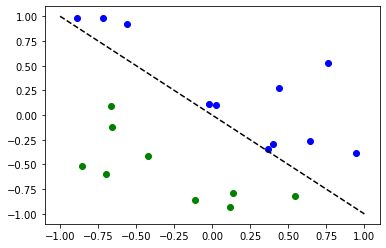

In [42]:
X = 2*np.random.rand(num_samples, num_inputs) - 1
y01 = 1*(np.sum(X, axis=1) >= 0)  # in { 0,  1}
y = 2*y01-1                       # in {-1, +1}
y_one_hot = np.zeros((num_samples, 2))
for i in range(num_samples):
    y_one_hot[i, y01[i]] = 1

for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
plt.plot([-1, 1], [1, -1], '--', color='black')
plt.show()

В туториале предлагаются три способа построения классификатора:
* [CircuitQNN](#CircuitQNN)
* [TwoLayerQNN](#TwoLayerQNN)

Рассмотрим каждый из способов подробнее

## CircuitQNN

In [4]:
from qiskit_machine_learning.neural_networks import CircuitQNN

In [16]:
ansatz = RealAmplitudes(num_inputs, reps=1)

[RealAmplitudes](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RealAmplitudes.html) - эвристическая волновая функция, которая используется в качестве _анзаца_ в схемах классификаторов, а ещё в химических приложениях.

> Анзац - термин из теоретической физики, который обозначает догадку о том, какую форму должно иметь решение некоторого уравнения, например вид функции, которой можно представить решение.

Схема включает в себя последоватльность RY поворотов и CX запутанностей:

In [17]:
print(ansatz)

     ┌──────────┐     ┌──────────┐
q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[2]) ├
     ├──────────┤┌─┴─┐├──────────┤
q_1: ┤ Ry(θ[1]) ├┤ X ├┤ Ry(θ[3]) ├
     └──────────┘└───┘└──────────┘


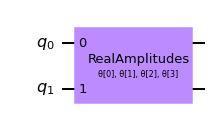

In [18]:
ansatz.draw(output='mpl')

Зададим карту признаков

In [19]:
feature_map = ZZFeatureMap(num_inputs)

[ZZFeatureMap](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html) - схема Pauli-Z второго порядка.

Схема Pauli Expansion, в свою очередь, это операция над входным вектором $x$:
$$
U_{\Phi(\vec{x})}=\exp\left(i\sum_{S\subseteq [n]}
\phi_S(\vec{x})\prod_{i\in S} P_i\right)
$$

In [20]:
print(feature_map)

     ┌───┐┌──────────────┐                                           ┌───┐»
q_0: ┤ H ├┤ U1(2.0*x[0]) ├──■─────────────────────────────────────■──┤ H ├»
     ├───┤├──────────────┤┌─┴─┐┌───────────────────────────────┐┌─┴─┐├───┤»
q_1: ┤ H ├┤ U1(2.0*x[1]) ├┤ X ├┤ U1(2.0*(π - x[0])*(π - x[1])) ├┤ X ├┤ H ├»
     └───┘└──────────────┘└───┘└───────────────────────────────┘└───┘└───┘»
«     ┌──────────────┐                                           
«q_0: ┤ U1(2.0*x[0]) ├──■─────────────────────────────────────■──
«     ├──────────────┤┌─┴─┐┌───────────────────────────────┐┌─┴─┐
«q_1: ┤ U1(2.0*x[1]) ├┤ X ├┤ U1(2.0*(π - x[0])*(π - x[1])) ├┤ X ├
«     └──────────────┘└───┘└───────────────────────────────┘└───┘


Инициализируем схему из заданных элементов:

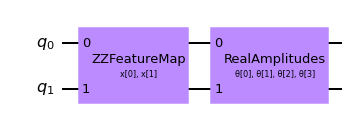

In [21]:
# construct quantum circuit
qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))
qc.decompose().draw(output='mpl')

Таким образом, у нас есть "слой" схемы с некоторым преобразованием входного вектора $x$ и "слой", отвечающий непосредственно за классификацию

Функция-утилита, которая проверяет чётность суммы единиц в двоичном представлении числа

In [39]:
'{:b}'.format(11)

'1011'

In [24]:
# parity maps bitstrings to 0 or 1
def parity(x):
    return '{:b}'.format(x).count('1') % 2

Размерность выхода равна 2 (бинарная классификация)

In [25]:
output_shape = 2  # corresponds to the number of classes, possible outcomes of the (parity) mapping.

Переходим к более высокоуровневой абстракции - [CircuitQNN](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.neural_networks.CircuitQNN.html), которая строит нейронную сеть на основе заданных размерностей и схемы

In [40]:
# construct QNN
circuit_qnn = CircuitQNN(circuit=qc,
                         input_params=feature_map.parameters,
                         weight_params=ansatz.parameters,
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

Добавляем нашей НН специфики и превращаем ещё в классификатор [NeuralNetworkClassifier](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.algorithms.NeuralNetworkClassifier.html). Эта обёртка предоставляет `fit()/predict()` интерфейс, а также позвояет задать оптимизатор. В нашем случае этот оптимизатор [COBYLA](https://qiskit.org/documentation/stubs/qiskit.aqua.components.optimizers.COBYLA.html):  Constrained Optimization BY Linear Approximation (COBYLA) algorithm. Этот алгоритм [представлен](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-cobyla.html#optimize-minimize-cobyla) и в SciPy  

In [44]:
# construct classifier
circuit_classifier = NeuralNetworkClassifier(neural_network=circuit_qnn,
                                             optimizer=COBYLA(),
                                             callback=callback_graph)

Функция-утилита, чтобы отрисовывать целевую функцию во время обучения

In [43]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [45]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

Запускаем обучение:

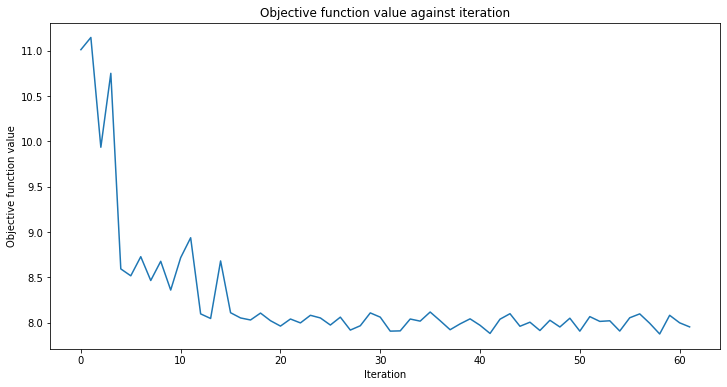

In [49]:
# fit classifier to data
circuit_classifier.fit(X, y01)

In [50]:
# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

... и `predict()`:

In [51]:
# score classifier
circuit_classifier.score(X, y01)

0.7

Посмотрим, на каких точках классификатор ошибся:

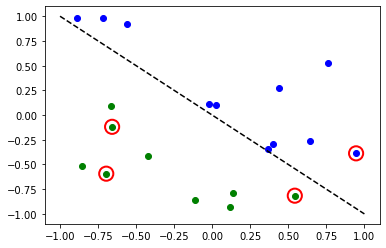

In [52]:
# evaluate data points
y_predict = circuit_classifier.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.plot([-1, 1], [1, -1], '--', color='black')
plt.show()

## TwoLayerQNN

Рассмотрим более высокоуровневое API для создания классификатора. Класс [TwoLayerQNN](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.neural_networks.TwoLayerQNN.html) - двухслойная QNN, которая уже включает в себя и карту признаков (feature map), и анзац (ansatz)

In [73]:
# construct QNN
opflow_qnn = TwoLayerQNN(num_inputs, quantum_instance=quantum_instance)

In [74]:
opflow_qnn.num_weights

8

Попробуем пропустить через классификатор одну точку. В качестве весов сгенерируем случайные числа

In [75]:
X[0, :]

array([ 0.94534464, -0.38709299])

In [76]:
# QNN maps inputs to [-1, +1]
opflow_qnn.forward(X[0, :], np.random.rand(opflow_qnn.num_weights))

array([[0.63476562]])

выход можно трактовать как метку класса

Применим знакомую обёртку для создания классификатора NeuralNetworkClassifier:

In [77]:
# construct neural network classifier
opflow_classifier = NeuralNetworkClassifier(opflow_qnn, optimizer=COBYLA(), callback=callback_graph)

... и запустим обучение:

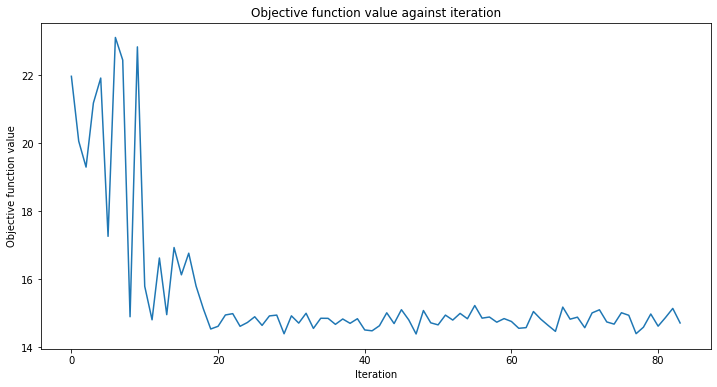

In [78]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
opflow_classifier.fit(X, y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

Результат:

In [79]:
# score classifier
opflow_classifier.score(X, y)

0.75

Посмотрим на ошибки:

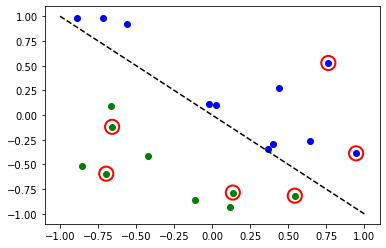

In [80]:
# evaluate data points
y_predict = opflow_classifier.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.plot([-1, 1], [1, -1], '--', color='black')
plt.show()